In [ ]:
import pandas as pd
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
from statsmodels.formula.api import ols
from linearmodels.panel import PanelOLS


file_path = '/Users/rebeccluo/Downloads/US_Paid_leave_analysis.dta'

# Load the file into a DataFrame
df = pd.read_stata(file_path)
print(df.columns.tolist())
print(df.shape)

['ssuid', 'spanel', 'swave', 'srefmon', 'rhcalmn', 'rhcalyr', 'tfipsst', 'epppnum', 'esex', 'wpfinwgt', 'tage', 'eeducate', 'rmesr', 'birth_month', 'sippid', 'months', 'date', 'birth', 'birth_seen_f', 'birth_seen', 'ref_month_ns', 'ref_month', 'state', 'end_date', 'end_weight_f', 'end_weight', 'CA_date', 'NJ_date', 'post_policy', 'rm_lfp', 'working', 'looking', 'lt_college_f', 'lt_college', 'Birth', '_IBirth_2', '_IBirth_3', '_IBirth_4', '_IBirth_5', '_IBirth_6', '_IBirth_7', '_IBirth_8', '_IBirth_9', '_IBirth_10', '_IBirth_11', '_IBirth_12', '_IBirth_13', '_IBirth_14', '_IBirth_15', '_IBirth_16', '_IBirth_17', '_IBirth_18', '_IBirth_19', '_IBirth_20', '_IBirth_21', '_IBirth_22', '_IBirth_23', '_IBirth_24', '_IBirth_25', '_IBirth_26', '_IBirth_27', '_IBirth_28', '_IBirth_29', '_IBirth_30', '_IBirth_31', '_IBirth_32', '_IBirth_33', '_IBirth_34', '_IBirth_35', '_IBirth_36', '_IBirth_37', '_IBirth_38', '_IBirth_39', '_IBirth_40', '_IBirth_41', '_IBirth_42', '_IBirth_43', '_IBirth_44', '_I

In [ ]:
unique_data = df.drop_duplicates(subset='sippid').dropna(subset=['rm_lfp'])
print(unique_data.shape)

(2816, 231)


In [ ]:
birth_vars = [f'_IBirth_{i}' for i in range(2, 52)]  # Birth dummies from _IBirth_2 to _IBirth_51
birxpos_vars = [f'_IBirXpos_{i}_1' for i in range(2, 52)]  # Event-study dummies _IBirXpos_2_1 to _IBirXpos_50_1
llbirth_vars = [f'_LlBirth_{2}_1'] + [f'_LlBirth_{i}_1' for i in range(8, 51)]   # Reference period dummies from _LlBirth_8 to _LlBirth_50
llbipos_vars = [f'_LlBiXpos_{2}_1'] + [f'_LlBiXpos_{i}_1' for i in range(8, 51)]  # Event-study reference period _LlBiXpos_8_1 to _LlBiXpos_50_1, what we are interested in


In [11]:
import warnings

# Suppress all warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    year_dummies = pd.get_dummies(unique_data['rhcalyr'], drop_first=True)  # Time dummy for year
    birth_dummies = pd.get_dummies(unique_data[birth_vars], drop_first=False)  # Dummies for birth_vars
    state_dummies = pd.get_dummies(unique_data['state'], drop_first=True)  # Dummies for states (assuming 'state' column)
    sippid_dummies = pd.get_dummies(unique_data['sippid'], prefix='sippid', drop_first=True)
    month_dummies = pd.get_dummies(unique_data['ref_month'], prefix='month', drop_first=True)
    edu_dummies = pd.get_dummies(unique_data['lt_college'], prefix='college', drop_first=True)
    age_group_dummies = pd.get_dummies(unique_data['age_group'],prefix='age', drop_first=True)  # Dummies for age groups
    recession_dummies = pd.get_dummies(unique_data['recession_birth'],prefix='recession', drop_first=True)  # Dummies for recession years

    
    age_recession_interactions = pd.DataFrame(index=unique_data.index)
    for age_col in age_group_dummies.columns:
        for recession_col in recession_dummies.columns:
            interaction_name = f'{age_col}_recession_{recession_col}'
            age_recession_interactions[interaction_name] = age_group_dummies[age_col] * recession_dummies[recession_col]



    # Step 2: Create interaction terms between birth_vars and time (rhcalyr)
    birth_time_interactions = pd.DataFrame(index=unique_data.index)
    for birth_col in birth_dummies.columns:
        for year_col in year_dummies.columns:
            interaction_name = f'{birth_col}_time_{year_col}'
            birth_time_interactions[interaction_name] = birth_dummies[birth_col] * year_dummies[year_col]

    # Step 3: Create interaction terms between birth_vars and state
    birth_state_interactions = pd.DataFrame(index=unique_data.index)
    for birth_col in birth_dummies.columns:
        for state_col in state_dummies.columns:
            interaction_name = f'{birth_col}_state_{state_col}'
            birth_state_interactions[interaction_name] = birth_dummies[birth_col] * state_dummies[state_col]
            
    state_edu_interactions = pd.DataFrame(index=unique_data.index)
    for state_col in state_dummies.columns:
        for edu_col in edu_dummies.columns:
            interaction_name = f'{state_col}_edu_{edu_col}'  # Name the interaction term
            state_edu_interactions[interaction_name] = state_dummies[state_col] * edu_dummies[edu_col]

    state_year_interactions = pd.DataFrame(index=unique_data.index)
    for state_col in state_dummies.columns:
        for year_col in year_dummies.columns:
            interaction_name = f'{state_col}_time_{year_col}'
            state_year_interactions[interaction_name] = state_dummies[state_col] * year_dummies[year_col]

X = pd.concat([year_dummies,state_dummies,age_group_dummies,
    recession_dummies,age_recession_interactions,month_dummies,state_year_interactions,edu_dummies], axis=1)

#no missing values
X = X.fillna(0)
X.columns = X.columns.astype(str)

#complete feature matrix ready for analysis or modeling
print(X.shape)

(2816, 95)


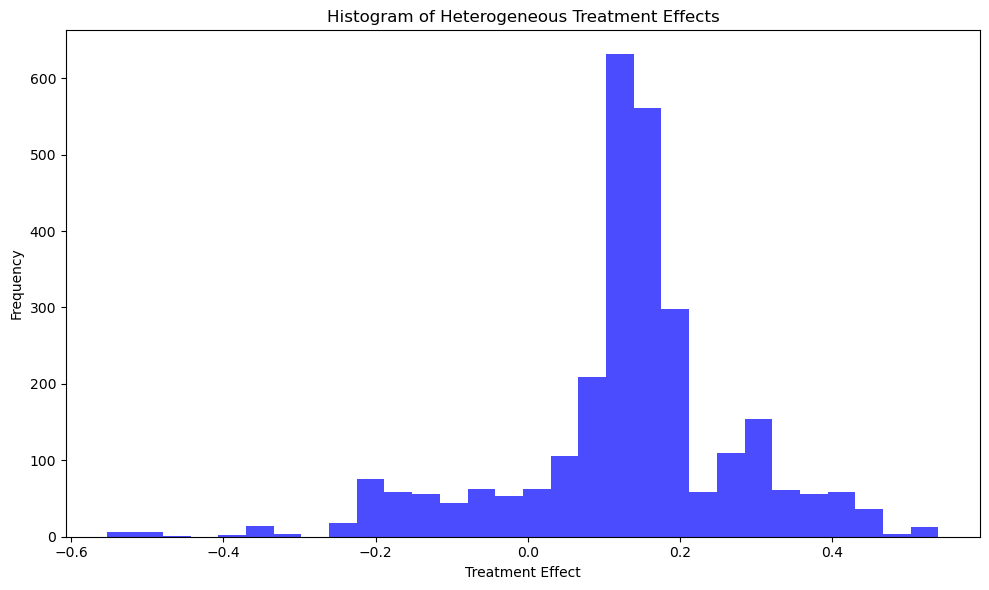

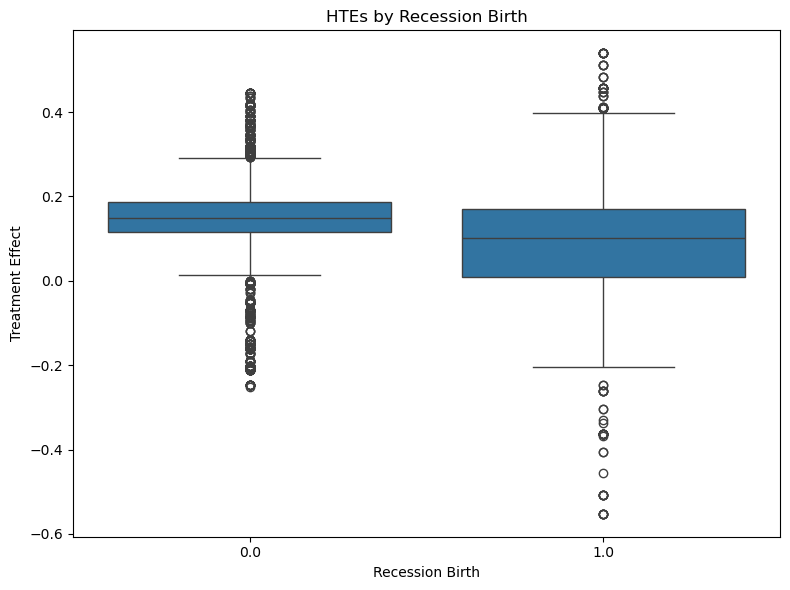

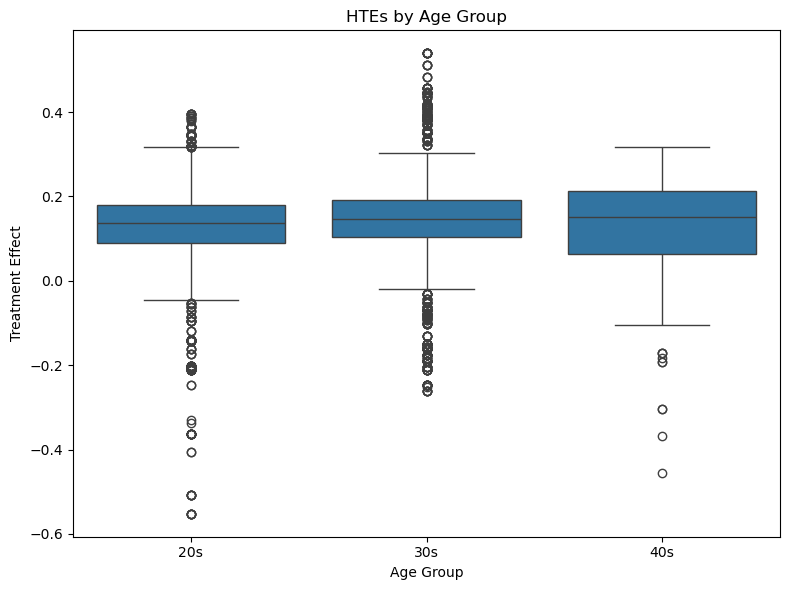

Heterogeneous Treatment Effects Summary:
Mean Treatment Effect: 0.1309
Median Treatment Effect: 0.1392
Standard Deviation: 0.1507
Minimum Effect: -0.5521
Maximum Effect: 0.5393
95% Confidence Interval: [-0.2062, 0.4108]


In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from econml.dml import CausalForestDML
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

def run_causal_forest(data, X):
    
    Y = data['rm_lfp'].values
    T = data['post_policy'].values
    

    if isinstance(X, pd.DataFrame):
        X = X.values
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # CausalForestDML model
    causal_forest = CausalForestDML(
        model_t=LogisticRegression(max_iter=1000),  # Classifier for binary treatment
        model_y=RandomForestRegressor(n_estimators=100, max_depth=5),
        discrete_treatment=True,  # Indicate treatment is discrete
        n_estimators=1000,  # Number of trees in the forest
        min_samples_leaf=5,
        max_depth=10
    )
    
    # Fit the model
    causal_forest.fit(Y, T, X=X_scaled, W=None)
    
    # Estimate HTEs for each individual
    treatment_effects = causal_forest.effect(X_scaled)
    
    return treatment_effects, causal_forest

def plot_histogram_of_htes(treatment_effects):
    
    plt.figure(figsize=(10, 6))
    plt.hist(treatment_effects, bins=30, color='blue', alpha=0.7)
    plt.title('Histogram of Heterogeneous Treatment Effects')
    plt.xlabel('Treatment Effect')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

def plot_htes_by_recession_birth(treatment_effects, data):
    
    plt.figure(figsize=(8, 6))
    hte_df = pd.DataFrame({
        'treatment_effects': treatment_effects,
        'recession_birth': data['recession_birth']
    })
    sns.boxplot(x='recession_birth', y='treatment_effects', data=hte_df)
    plt.title('HTEs by Recession Birth')
    plt.xlabel('Recession Birth')
    plt.ylabel('Treatment Effect')
    plt.tight_layout()
    plt.show()

def plot_htes_by_age_group(treatment_effects, data):
    
    plt.figure(figsize=(8, 6))
    hte_df = pd.DataFrame({
        'treatment_effects': treatment_effects,
        'age_group': data['age_group']
    })
    sns.boxplot(x='age_group', y='treatment_effects', data=hte_df)
    plt.title('HTEs by Age Group')
    plt.xlabel('Age Group')
    plt.ylabel('Treatment Effect')
    plt.tight_layout()
    plt.show()

def summarize_treatment_effects(treatment_effects):
    
    print("Heterogeneous Treatment Effects Summary:")
    print(f"Mean Treatment Effect: {np.mean(treatment_effects):.4f}")
    print(f"Median Treatment Effect: {np.median(treatment_effects):.4f}")
    print(f"Standard Deviation: {np.std(treatment_effects):.4f}")
    print(f"Minimum Effect: {np.min(treatment_effects):.4f}")
    print(f"Maximum Effect: {np.max(treatment_effects):.4f}")
    
    # Confidence intervals
    ci_lower = np.percentile(treatment_effects, 2.5)
    ci_upper = np.percentile(treatment_effects, 97.5)
    print(f"95% Confidence Interval: [{ci_lower:.4f}, {ci_upper:.4f}]")

def main(data, X):
    
    # Run causal forest to estimate HTEs
    treatment_effects, causal_forest = run_causal_forest(data, X)
    
    # Visualize treatment effects
    plot_histogram_of_htes(treatment_effects)
    plot_htes_by_recession_birth(treatment_effects, data)
    plot_htes_by_age_group(treatment_effects, data)
    
    # Summarize treatment effects
    summarize_treatment_effects(treatment_effects)
    
    return treatment_effects


treatment_effects = main(unique_data, X)